## c. charRNN Gradient Clipping

In [5]:
histories = {}

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import matplotlib.pyplot as plt
import time

MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
FILTER_SHAPE1 = [20, 256]
FILTER_SHAPE2 = [20, 1]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
HIDDEN_SIZE = 20
EMBEDDING_SIZE = 20
MAX_LABEL = 15

batch_size = 128
one_hot_size = 256
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)

# Read data with [character]
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))


    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = read_data_chars()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Build model
tf.keras.backend.set_floatx('float32')

In [7]:
class CharRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20):
        super(CharRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, one_hot_size)
        #print(x.shape)
        encoding = self.rnn(x)
        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = CharRNN(256,HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr,clipvalue=2)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charRNN_GRU'] = history

Epoch 1, Loss: 2.6670541763305664, Accuracy: 0.08303571492433548, Test Loss: 2.619434118270874, Test Accuracy: 0.10428571701049805
Epoch 2, Loss: 2.609372138977051, Accuracy: 0.10321428626775742, Test Loss: 2.578143358230591, Test Accuracy: 0.10428571701049805
Epoch 3, Loss: 2.4866859912872314, Accuracy: 0.14017857611179352, Test Loss: 2.33544659614563, Test Accuracy: 0.1785714328289032
Epoch 4, Loss: 2.2642245292663574, Accuracy: 0.1882142871618271, Test Loss: 2.1275722980499268, Test Accuracy: 0.25999999046325684
Epoch 5, Loss: 2.0632898807525635, Accuracy: 0.26053571701049805, Test Loss: 1.9377126693725586, Test Accuracy: 0.32428571581840515
Epoch 6, Loss: 1.86329984664917, Accuracy: 0.33517858386039734, Test Loss: 1.777284026145935, Test Accuracy: 0.37714284658432007
Epoch 7, Loss: 1.7163958549499512, Accuracy: 0.38624998927116394, Test Loss: 1.6365338563919067, Test Accuracy: 0.4099999964237213
Epoch 8, Loss: 1.5977835655212402, Accuracy: 0.42875000834465027, Test Loss: 1.59961688

Epoch 64, Loss: 0.8344618082046509, Accuracy: 0.7219642996788025, Test Loss: 0.9435105919837952, Test Accuracy: 0.7185714244842529
Epoch 65, Loss: 0.8023915886878967, Accuracy: 0.7301785945892334, Test Loss: 1.0069499015808105, Test Accuracy: 0.6957142949104309
Epoch 66, Loss: 0.7547160983085632, Accuracy: 0.739464282989502, Test Loss: 0.9797075390815735, Test Accuracy: 0.6957142949104309
Epoch 67, Loss: 0.7971601486206055, Accuracy: 0.7351785898208618, Test Loss: 0.9920024871826172, Test Accuracy: 0.691428542137146
Epoch 68, Loss: 0.8123984932899475, Accuracy: 0.7278571724891663, Test Loss: 1.0075470209121704, Test Accuracy: 0.7085714340209961
Epoch 69, Loss: 0.7480931878089905, Accuracy: 0.7442857027053833, Test Loss: 0.9724671840667725, Test Accuracy: 0.7085714340209961
Epoch 70, Loss: 0.7822616696357727, Accuracy: 0.7362499833106995, Test Loss: 1.0273544788360596, Test Accuracy: 0.6942856907844543
Epoch 71, Loss: 0.7969850897789001, Accuracy: 0.7225000262260437, Test Loss: 1.020924

Epoch 127, Loss: 0.8442321419715881, Accuracy: 0.7260714173316956, Test Loss: 1.0349841117858887, Test Accuracy: 0.6885714530944824
Epoch 128, Loss: 0.8280269503593445, Accuracy: 0.7201785445213318, Test Loss: 0.9480772018432617, Test Accuracy: 0.7071428298950195
Epoch 129, Loss: 0.7230386734008789, Accuracy: 0.7523214221000671, Test Loss: 0.9953065514564514, Test Accuracy: 0.7071428298950195
Epoch 130, Loss: 0.6847463250160217, Accuracy: 0.7642857432365417, Test Loss: 1.0094279050827026, Test Accuracy: 0.7314285635948181
Epoch 131, Loss: 0.6547621488571167, Accuracy: 0.7816071510314941, Test Loss: 1.0000301599502563, Test Accuracy: 0.7328571677207947
Epoch 132, Loss: 0.6769885420799255, Accuracy: 0.7682142853736877, Test Loss: 1.0334969758987427, Test Accuracy: 0.7214285731315613
Epoch 133, Loss: 0.6852929592132568, Accuracy: 0.7669642567634583, Test Loss: 1.0367627143859863, Test Accuracy: 0.7171428799629211
Epoch 134, Loss: 0.6658504009246826, Accuracy: 0.7682142853736877, Test Loss

Epoch 190, Loss: 0.6444862484931946, Accuracy: 0.7785714268684387, Test Loss: 1.0707234144210815, Test Accuracy: 0.704285740852356
Epoch 191, Loss: 0.6466699242591858, Accuracy: 0.7789285778999329, Test Loss: 1.083669662475586, Test Accuracy: 0.6971428394317627
Epoch 192, Loss: 0.6318299770355225, Accuracy: 0.7842857241630554, Test Loss: 1.1796611547470093, Test Accuracy: 0.7071428298950195
Epoch 193, Loss: 0.6260160803794861, Accuracy: 0.7891071438789368, Test Loss: 1.1178981065750122, Test Accuracy: 0.7014285922050476
Epoch 194, Loss: 0.6101287603378296, Accuracy: 0.7930356860160828, Test Loss: 1.1980820894241333, Test Accuracy: 0.7114285826683044
Epoch 195, Loss: 0.6109491586685181, Accuracy: 0.7905356884002686, Test Loss: 1.1101233959197998, Test Accuracy: 0.7099999785423279
Epoch 196, Loss: 0.5867264270782471, Accuracy: 0.7994642853736877, Test Loss: 1.1579946279525757, Test Accuracy: 0.7085714340209961
Epoch 197, Loss: 0.619206964969635, Accuracy: 0.7864285707473755, Test Loss: 1

In [8]:
class CharRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20):
        super(CharRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.SimpleRNNCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, one_hot_size)
        #print(x.shape)
        encoding = self.rnn(x)
        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = CharRNN(256,HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr,clipvalue=2)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charRNN_vanilla'] = history

Epoch 1, Loss: 2.695775032043457, Accuracy: 0.0669642835855484, Test Loss: 2.644651174545288, Test Accuracy: 0.09142857044935226
Epoch 2, Loss: 2.6421587467193604, Accuracy: 0.09017857164144516, Test Loss: 2.622252941131592, Test Accuracy: 0.09428571164608002
Epoch 3, Loss: 2.61954927444458, Accuracy: 0.09678571671247482, Test Loss: 2.588907480239868, Test Accuracy: 0.11857143044471741
Epoch 4, Loss: 2.5988664627075195, Accuracy: 0.11178571730852127, Test Loss: 2.612499952316284, Test Accuracy: 0.10000000149011612
Epoch 5, Loss: 2.6021342277526855, Accuracy: 0.1103571429848671, Test Loss: 2.6155288219451904, Test Accuracy: 0.09714286029338837
Epoch 6, Loss: 2.602435350418091, Accuracy: 0.10892856866121292, Test Loss: 2.602644681930542, Test Accuracy: 0.10571428388357162
Epoch 7, Loss: 2.605701208114624, Accuracy: 0.11678571254014969, Test Loss: 2.623549699783325, Test Accuracy: 0.08714285492897034
Epoch 8, Loss: 2.636741876602173, Accuracy: 0.11178571730852127, Test Loss: 2.66183114051

Epoch 64, Loss: 2.6347711086273193, Accuracy: 0.09339285641908646, Test Loss: 2.6255064010620117, Test Accuracy: 0.10999999940395355
Epoch 65, Loss: 2.639145851135254, Accuracy: 0.08874999731779099, Test Loss: 2.6222736835479736, Test Accuracy: 0.10285714268684387
Epoch 66, Loss: 2.6323771476745605, Accuracy: 0.08571428805589676, Test Loss: 2.6305482387542725, Test Accuracy: 0.10999999940395355
Epoch 67, Loss: 2.6364338397979736, Accuracy: 0.08982142806053162, Test Loss: 2.622307300567627, Test Accuracy: 0.09714286029338837
Epoch 68, Loss: 2.6275479793548584, Accuracy: 0.09125000238418579, Test Loss: 2.631068468093872, Test Accuracy: 0.10428571701049805
Epoch 69, Loss: 2.635246753692627, Accuracy: 0.10035714507102966, Test Loss: 2.623878240585327, Test Accuracy: 0.08428571373224258
Epoch 70, Loss: 2.6358232498168945, Accuracy: 0.09321428835391998, Test Loss: 2.628547430038452, Test Accuracy: 0.09000000357627869
Epoch 71, Loss: 2.6319565773010254, Accuracy: 0.09446428716182709, Test Los

Epoch 126, Loss: 2.6193132400512695, Accuracy: 0.1026785746216774, Test Loss: 2.609367609024048, Test Accuracy: 0.10000000149011612
Epoch 127, Loss: 2.614497661590576, Accuracy: 0.10214285552501678, Test Loss: 2.6041719913482666, Test Accuracy: 0.09857142716646194
Epoch 128, Loss: 2.6226744651794434, Accuracy: 0.10053571313619614, Test Loss: 2.6163437366485596, Test Accuracy: 0.10285714268684387
Epoch 129, Loss: 2.6153628826141357, Accuracy: 0.10035714507102966, Test Loss: 2.613093614578247, Test Accuracy: 0.12285714596509933
Epoch 130, Loss: 2.6183021068573, Accuracy: 0.10000000149011612, Test Loss: 2.6169774532318115, Test Accuracy: 0.09857142716646194
Epoch 131, Loss: 2.6074206829071045, Accuracy: 0.10767856985330582, Test Loss: 2.605889081954956, Test Accuracy: 0.11428571492433548
Epoch 132, Loss: 2.5950868129730225, Accuracy: 0.11625000089406967, Test Loss: 2.5969481468200684, Test Accuracy: 0.10428571701049805
Epoch 133, Loss: 2.590162515640259, Accuracy: 0.1148214265704155, Test

Epoch 188, Loss: 2.616788625717163, Accuracy: 0.09785714000463486, Test Loss: 2.6042022705078125, Test Accuracy: 0.09714286029338837
Epoch 189, Loss: 2.6110620498657227, Accuracy: 0.10696428269147873, Test Loss: 2.596818208694458, Test Accuracy: 0.1128571406006813
Epoch 190, Loss: 2.6142075061798096, Accuracy: 0.10357142984867096, Test Loss: 2.5960724353790283, Test Accuracy: 0.11571428924798965
Epoch 191, Loss: 2.5995683670043945, Accuracy: 0.10964285582304001, Test Loss: 2.5940754413604736, Test Accuracy: 0.1014285683631897
Epoch 192, Loss: 2.6058199405670166, Accuracy: 0.10875000059604645, Test Loss: 2.5976762771606445, Test Accuracy: 0.1071428582072258
Epoch 193, Loss: 2.6190085411071777, Accuracy: 0.09839285910129547, Test Loss: 2.5857932567596436, Test Accuracy: 0.10571428388357162
Epoch 194, Loss: 2.606090545654297, Accuracy: 0.10803571343421936, Test Loss: 2.5978212356567383, Test Accuracy: 0.10285714268684387
Epoch 195, Loss: 2.6097164154052734, Accuracy: 0.11142857372760773, 

Epoch 250, Loss: 2.6313681602478027, Accuracy: 0.09535714238882065, Test Loss: 2.617918014526367, Test Accuracy: 0.11142857372760773


In [9]:
class CharRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20):
        super(CharRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.LSTMCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, one_hot_size)
        #print(x.shape)
        encoding = self.rnn(x)
        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = CharRNN(256,HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr,clipvalue=2)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charRNN_LSTM'] = history

Epoch 1, Loss: 2.672546148300171, Accuracy: 0.08267857134342194, Test Loss: 2.6245222091674805, Test Accuracy: 0.11714285612106323
Epoch 2, Loss: 2.6148276329040527, Accuracy: 0.11392857134342194, Test Loss: 2.5806400775909424, Test Accuracy: 0.1128571406006813
Epoch 3, Loss: 2.5891411304473877, Accuracy: 0.12553571164608002, Test Loss: 2.6529834270477295, Test Accuracy: 0.1014285683631897
Epoch 4, Loss: 2.5728888511657715, Accuracy: 0.11749999970197678, Test Loss: 2.5593950748443604, Test Accuracy: 0.13428571820259094
Epoch 5, Loss: 2.603574275970459, Accuracy: 0.11089285463094711, Test Loss: 2.593121290206909, Test Accuracy: 0.11714285612106323
Epoch 6, Loss: 2.5826053619384766, Accuracy: 0.11392857134342194, Test Loss: 2.506540536880493, Test Accuracy: 0.1428571492433548
Epoch 7, Loss: 2.621530771255493, Accuracy: 0.10999999940395355, Test Loss: 2.625511884689331, Test Accuracy: 0.08714285492897034
Epoch 8, Loss: 2.612464189529419, Accuracy: 0.09749999642372131, Test Loss: 2.5836393

Epoch 64, Loss: 1.1567267179489136, Accuracy: 0.5682142972946167, Test Loss: 1.2543587684631348, Test Accuracy: 0.5214285850524902
Epoch 65, Loss: 1.145037055015564, Accuracy: 0.5626785755157471, Test Loss: 1.2144101858139038, Test Accuracy: 0.5485714077949524
Epoch 66, Loss: 1.167074203491211, Accuracy: 0.5603571534156799, Test Loss: 1.2199652194976807, Test Accuracy: 0.550000011920929
Epoch 67, Loss: 1.1419763565063477, Accuracy: 0.568928599357605, Test Loss: 1.1823824644088745, Test Accuracy: 0.5285714268684387
Epoch 68, Loss: 1.1243897676467896, Accuracy: 0.5712500214576721, Test Loss: 1.20586359500885, Test Accuracy: 0.5371428728103638
Epoch 69, Loss: 1.169244647026062, Accuracy: 0.5625, Test Loss: 1.2479605674743652, Test Accuracy: 0.5699999928474426
Epoch 70, Loss: 1.210178017616272, Accuracy: 0.5505357384681702, Test Loss: 1.3243513107299805, Test Accuracy: 0.5214285850524902
Epoch 71, Loss: 1.160508632659912, Accuracy: 0.5683928728103638, Test Loss: 1.2058621644973755, Test Ac

Epoch 127, Loss: 1.1182512044906616, Accuracy: 0.5891071557998657, Test Loss: 1.2181366682052612, Test Accuracy: 0.5857142806053162
Epoch 128, Loss: 1.098280429840088, Accuracy: 0.5998214483261108, Test Loss: 1.2110759019851685, Test Accuracy: 0.6085714101791382
Epoch 129, Loss: 1.0889452695846558, Accuracy: 0.602321445941925, Test Loss: 1.2220357656478882, Test Accuracy: 0.6057142615318298
Epoch 130, Loss: 1.0735543966293335, Accuracy: 0.6064285635948181, Test Loss: 1.1671696901321411, Test Accuracy: 0.5942857265472412
Epoch 131, Loss: 1.0511345863342285, Accuracy: 0.6075000166893005, Test Loss: 1.171162486076355, Test Accuracy: 0.6000000238418579
Epoch 132, Loss: 1.048072338104248, Accuracy: 0.612678587436676, Test Loss: 1.1884435415267944, Test Accuracy: 0.6057142615318298
Epoch 133, Loss: 1.0544463396072388, Accuracy: 0.6108928322792053, Test Loss: 1.1581743955612183, Test Accuracy: 0.6128571629524231
Epoch 134, Loss: 1.0492531061172485, Accuracy: 0.6091071367263794, Test Loss: 1.1

Epoch 190, Loss: 1.0142450332641602, Accuracy: 0.6216071248054504, Test Loss: 1.1966019868850708, Test Accuracy: 0.6071428656578064
Epoch 191, Loss: 0.9953868389129639, Accuracy: 0.6328571438789368, Test Loss: 1.1672627925872803, Test Accuracy: 0.6157143115997314
Epoch 192, Loss: 0.9899482131004333, Accuracy: 0.6282142996788025, Test Loss: 1.2120431661605835, Test Accuracy: 0.6028571724891663
Epoch 193, Loss: 0.9767310619354248, Accuracy: 0.6341071724891663, Test Loss: 1.2109895944595337, Test Accuracy: 0.6214285492897034
Epoch 194, Loss: 0.9647252559661865, Accuracy: 0.637499988079071, Test Loss: 1.1939808130264282, Test Accuracy: 0.6142857074737549
Epoch 195, Loss: 0.9968589544296265, Accuracy: 0.6264285445213318, Test Loss: 1.1702827215194702, Test Accuracy: 0.6057142615318298
Epoch 196, Loss: 0.9512911438941956, Accuracy: 0.6378571391105652, Test Loss: 1.17987060546875, Test Accuracy: 0.6142857074737549
Epoch 197, Loss: 0.9867106080055237, Accuracy: 0.6312500238418579, Test Loss: 1

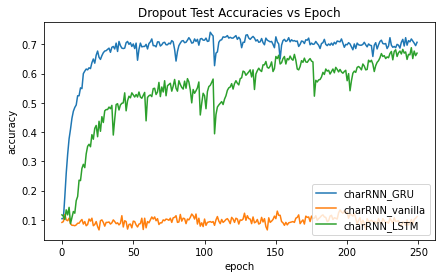

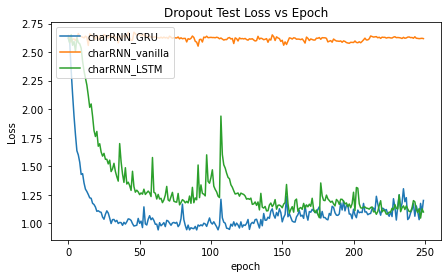

In [10]:
plt.figure(figsize=(7,4))
plt.plot(histories['charRNN_GRU']['test_acc'])
plt.plot(histories['charRNN_vanilla']['test_acc'])
plt.plot(histories['charRNN_LSTM']['test_acc'])
plt.title('Dropout Test Accuracies vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['charRNN_GRU','charRNN_vanilla','charRNN_LSTM'], loc='lower right')

plt.savefig(
    f'./results/partB_qn6_charRNN_clipping_accuracies.pdf'
)

plt.figure(figsize=(7,4))
plt.plot(histories['charRNN_GRU']['test_loss'])
plt.plot(histories['charRNN_vanilla']['test_loss'])
plt.plot(histories['charRNN_LSTM']['test_loss'])
plt.title('Dropout Test Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['charRNN_GRU','charRNN_vanilla','charRNN_LSTM'], loc='upper left')

plt.savefig(
    f'./results/partB_qn6_charRNN_clipping_loss.pdf'
)

## c. wordRNN Gradient Clipping

In [11]:
import numpy as np
import collections
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import nltk

nltk.download('punkt')

MAX_DOCUMENT_LENGTH = 100
EMBEDDING_SIZE = 20
MAX_LABEL = 15

batch_size = 128
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)


def clean_str(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()

    return text


def build_word_dict(contents):
    words = list()
    for content in contents:
        for word in word_tokenize(clean_str(content)):
            words.append(word)

    word_counter = collections.Counter(words).most_common()
    word_dict = dict()
    word_dict["<pad>"] = 0
    word_dict["<unk>"] = 1
    word_dict["<eos>"] = 2
    for word, _ in word_counter:
        word_dict[word] = len(word_dict)
    return word_dict


def preprocess(contents, word_dict, document_max_len):
    x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
    x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
    x = list(map(lambda d: d + [word_dict["<eos>"]], x))
    x = list(map(lambda d: d[:document_max_len], x))
    x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
    return x


def read_data_words():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    word_dict = build_word_dict(x_train+x_test)
    x_train = preprocess(x_train, word_dict, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, word_dict, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
    x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    vocab_size = tf.get_static_value(tf.reduce_max(x_train))
    vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1
    return x_train, y_train, x_test, y_test, vocab_size


x_train, y_train, x_test, y_test, vocab_size = read_data_words()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

[nltk_data] Downloading package punkt to C:\Users\Shearman
[nltk_data]     Chua\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
# Build model
tf.keras.backend.set_floatx('float32')
class WordRNN(Model):

    def __init__(self, vocab_size, hidden_dim=20):
        super(WordRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)

        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = WordRNN(vocab_size, HIDDEN_SIZE)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr,clipvalue=2)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['wordRNN_GRU'] = history

Epoch 1, Loss: 2.6795828342437744, Accuracy: 0.06714285910129547, Test Loss: 2.6548750400543213, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.655937433242798, Accuracy: 0.06517857313156128, Test Loss: 2.646360158920288, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.6524438858032227, Accuracy: 0.07053571194410324, Test Loss: 2.645477771759033, Test Accuracy: 0.07285714149475098
Epoch 4, Loss: 2.64945650100708, Accuracy: 0.06767857074737549, Test Loss: 2.641868829727173, Test Accuracy: 0.07000000029802322
Epoch 5, Loss: 2.509831190109253, Accuracy: 0.10875000059604645, Test Loss: 2.0841519832611084, Test Accuracy: 0.18285714089870453
Epoch 6, Loss: 1.8197791576385498, Accuracy: 0.3082142770290375, Test Loss: 1.4554743766784668, Test Accuracy: 0.5114285945892334
Epoch 7, Loss: 1.3583626747131348, Accuracy: 0.48053571581840515, Test Loss: 1.1114685535430908, Test Accuracy: 0.6514285802841187
Epoch 8, Loss: 0.9315138459205627, Accuracy: 0.668749988079071, Test Loss: 0.83300805091

Epoch 64, Loss: 0.07318241149187088, Accuracy: 0.977142870426178, Test Loss: 1.0990766286849976, Test Accuracy: 0.8714285492897034
Epoch 65, Loss: 0.062453512102365494, Accuracy: 0.977321445941925, Test Loss: 1.0732218027114868, Test Accuracy: 0.8614285588264465
Epoch 66, Loss: 0.06317675113677979, Accuracy: 0.9783928394317627, Test Loss: 1.1039117574691772, Test Accuracy: 0.8557142615318298
Epoch 67, Loss: 0.060834333300590515, Accuracy: 0.9807142615318298, Test Loss: 1.0101487636566162, Test Accuracy: 0.8642857074737549
Epoch 68, Loss: 0.06158559396862984, Accuracy: 0.9789285659790039, Test Loss: 1.0616252422332764, Test Accuracy: 0.8585714101791382
Epoch 69, Loss: 0.05068625137209892, Accuracy: 0.9823214411735535, Test Loss: 1.060458779335022, Test Accuracy: 0.8728571534156799
Epoch 70, Loss: 0.10970697551965714, Accuracy: 0.9682142734527588, Test Loss: 1.311524748802185, Test Accuracy: 0.8185714483261108
Epoch 71, Loss: 0.14571985602378845, Accuracy: 0.958392858505249, Test Loss: 1

Epoch 127, Loss: 0.03437625244259834, Accuracy: 0.9878571629524231, Test Loss: 1.480542778968811, Test Accuracy: 0.8471428751945496
Epoch 128, Loss: 0.0334680937230587, Accuracy: 0.9857142567634583, Test Loss: 1.4952160120010376, Test Accuracy: 0.8571428656578064
Epoch 129, Loss: 0.03528079017996788, Accuracy: 0.9860714077949524, Test Loss: 1.3418002128601074, Test Accuracy: 0.8585714101791382
Epoch 130, Loss: 0.04346904903650284, Accuracy: 0.983214259147644, Test Loss: 1.1679701805114746, Test Accuracy: 0.8614285588264465
Epoch 131, Loss: 0.038511041551828384, Accuracy: 0.985535740852356, Test Loss: 1.3072744607925415, Test Accuracy: 0.8628571629524231
Epoch 132, Loss: 0.04080041125416756, Accuracy: 0.9867857098579407, Test Loss: 1.3636846542358398, Test Accuracy: 0.8557142615318298
Epoch 133, Loss: 0.029912518337368965, Accuracy: 0.987678587436676, Test Loss: 1.5933561325073242, Test Accuracy: 0.8528571724891663
Epoch 134, Loss: 0.03167041763663292, Accuracy: 0.9892857074737549, Test

Epoch 189, Loss: 0.037972889840602875, Accuracy: 0.9851785898208618, Test Loss: 1.3182148933410645, Test Accuracy: 0.8528571724891663
Epoch 190, Loss: 0.03297898545861244, Accuracy: 0.9883928298950195, Test Loss: 1.1741305589675903, Test Accuracy: 0.8700000047683716
Epoch 191, Loss: 0.038719866424798965, Accuracy: 0.9891071319580078, Test Loss: 1.1332981586456299, Test Accuracy: 0.8628571629524231
Epoch 192, Loss: 0.04495280608534813, Accuracy: 0.9819642901420593, Test Loss: 1.2985707521438599, Test Accuracy: 0.8657143115997314
Epoch 193, Loss: 0.04111975058913231, Accuracy: 0.9882143139839172, Test Loss: 1.231679916381836, Test Accuracy: 0.8742856979370117
Epoch 194, Loss: 0.02913430891931057, Accuracy: 0.9889285564422607, Test Loss: 1.31621515750885, Test Accuracy: 0.8585714101791382
Epoch 195, Loss: 0.029387157410383224, Accuracy: 0.9901785850524902, Test Loss: 1.4489179849624634, Test Accuracy: 0.8428571224212646
Epoch 196, Loss: 0.027877720072865486, Accuracy: 0.9891071319580078, 

In [13]:
# Build model
tf.keras.backend.set_floatx('float32')
class WordRNN(Model):

    def __init__(self, vocab_size, hidden_dim=20):
        super(WordRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.SimpleRNNCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)

        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = WordRNN(vocab_size, HIDDEN_SIZE)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr,clipvalue=2)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['wordRNN_vanilla'] = history

Epoch 1, Loss: 2.6903481483459473, Accuracy: 0.06785714626312256, Test Loss: 2.6572582721710205, Test Accuracy: 0.08571428805589676
Epoch 2, Loss: 2.660130500793457, Accuracy: 0.07089285552501678, Test Loss: 2.649552345275879, Test Accuracy: 0.05714285746216774
Epoch 3, Loss: 2.657676935195923, Accuracy: 0.07178571075201035, Test Loss: 2.6472280025482178, Test Accuracy: 0.07428571581840515
Epoch 4, Loss: 2.6518144607543945, Accuracy: 0.07303571701049805, Test Loss: 2.6431901454925537, Test Accuracy: 0.08857142925262451
Epoch 5, Loss: 2.6478633880615234, Accuracy: 0.06803571432828903, Test Loss: 2.6459462642669678, Test Accuracy: 0.07000000029802322
Epoch 6, Loss: 2.647719383239746, Accuracy: 0.07607142627239227, Test Loss: 2.6413216590881348, Test Accuracy: 0.07428571581840515
Epoch 7, Loss: 2.6436898708343506, Accuracy: 0.07303571701049805, Test Loss: 2.641254186630249, Test Accuracy: 0.07285714149475098
Epoch 8, Loss: 2.6460154056549072, Accuracy: 0.07732142508029938, Test Loss: 2.64

Epoch 64, Loss: 2.6381351947784424, Accuracy: 0.07678571343421936, Test Loss: 2.6396994590759277, Test Accuracy: 0.07000000029802322
Epoch 65, Loss: 2.6407530307769775, Accuracy: 0.07160714268684387, Test Loss: 2.6476359367370605, Test Accuracy: 0.07428571581840515
Epoch 66, Loss: 2.642000913619995, Accuracy: 0.06428571790456772, Test Loss: 2.640071392059326, Test Accuracy: 0.07000000029802322
Epoch 67, Loss: 2.638944387435913, Accuracy: 0.07178571075201035, Test Loss: 2.6398632526397705, Test Accuracy: 0.07285714149475098
Epoch 68, Loss: 2.638035535812378, Accuracy: 0.0694642886519432, Test Loss: 2.640956163406372, Test Accuracy: 0.07285714149475098
Epoch 69, Loss: 2.63773512840271, Accuracy: 0.07124999910593033, Test Loss: 2.641296625137329, Test Accuracy: 0.07285714149475098
Epoch 70, Loss: 2.637606382369995, Accuracy: 0.07374999672174454, Test Loss: 2.640023946762085, Test Accuracy: 0.0714285746216774
Epoch 71, Loss: 2.637702703475952, Accuracy: 0.07410714030265808, Test Loss: 2.64

Epoch 127, Loss: 2.770256996154785, Accuracy: 0.07035714387893677, Test Loss: 2.7570221424102783, Test Accuracy: 0.06285714358091354
Epoch 128, Loss: 2.7259836196899414, Accuracy: 0.07196428626775742, Test Loss: 2.6645991802215576, Test Accuracy: 0.07571428269147873
Epoch 129, Loss: 2.708097219467163, Accuracy: 0.07821428775787354, Test Loss: 2.6827995777130127, Test Accuracy: 0.07000000029802322
Epoch 130, Loss: 2.6901838779449463, Accuracy: 0.0758928582072258, Test Loss: 2.6589269638061523, Test Accuracy: 0.0714285746216774
Epoch 131, Loss: 2.6836740970611572, Accuracy: 0.06928571313619614, Test Loss: 2.6523492336273193, Test Accuracy: 0.07000000029802322
Epoch 132, Loss: 2.673948287963867, Accuracy: 0.07285714149475098, Test Loss: 2.6627585887908936, Test Accuracy: 0.0714285746216774
Epoch 133, Loss: 2.682706832885742, Accuracy: 0.0682142823934555, Test Loss: 2.650134801864624, Test Accuracy: 0.07285714149475098
Epoch 134, Loss: 2.671522378921509, Accuracy: 0.07535714656114578, Test

Epoch 189, Loss: 2.662529945373535, Accuracy: 0.0682142823934555, Test Loss: 2.6445205211639404, Test Accuracy: 0.0714285746216774
Epoch 190, Loss: 2.6644060611724854, Accuracy: 0.06982143223285675, Test Loss: 2.645535707473755, Test Accuracy: 0.0714285746216774
Epoch 191, Loss: 2.6611251831054688, Accuracy: 0.07196428626775742, Test Loss: 2.6429738998413086, Test Accuracy: 0.0714285746216774
Epoch 192, Loss: 2.6593973636627197, Accuracy: 0.07071428745985031, Test Loss: 2.647369861602783, Test Accuracy: 0.07000000029802322
Epoch 193, Loss: 2.658975601196289, Accuracy: 0.06678571552038193, Test Loss: 2.6442759037017822, Test Accuracy: 0.07285714149475098
Epoch 194, Loss: 2.6649274826049805, Accuracy: 0.06857142597436905, Test Loss: 2.6418850421905518, Test Accuracy: 0.0714285746216774
Epoch 195, Loss: 2.662611484527588, Accuracy: 0.07303571701049805, Test Loss: 2.64408540725708, Test Accuracy: 0.0714285746216774
Epoch 196, Loss: 2.6677567958831787, Accuracy: 0.06624999642372131, Test Lo

In [14]:
# Build model
tf.keras.backend.set_floatx('float32')
class WordRNN(Model):

    def __init__(self, vocab_size, hidden_dim=20):
        super(WordRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.LSTMCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)

        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = WordRNN(vocab_size, HIDDEN_SIZE)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr,clipvalue=2)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['wordRNN_LSTM'] = history

Epoch 1, Loss: 2.680792808532715, Accuracy: 0.07410714030265808, Test Loss: 2.656146287918091, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.6596624851226807, Accuracy: 0.06839285790920258, Test Loss: 2.6463072299957275, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.6521055698394775, Accuracy: 0.0701785683631897, Test Loss: 2.645509958267212, Test Accuracy: 0.0714285746216774
Epoch 4, Loss: 2.6497552394866943, Accuracy: 0.07160714268684387, Test Loss: 2.641977548599243, Test Accuracy: 0.0714285746216774
Epoch 5, Loss: 2.647456169128418, Accuracy: 0.06178571283817291, Test Loss: 2.6424400806427, Test Accuracy: 0.07285714149475098
Epoch 6, Loss: 2.644801139831543, Accuracy: 0.0694642886519432, Test Loss: 2.641248941421509, Test Accuracy: 0.0714285746216774
Epoch 7, Loss: 2.6448566913604736, Accuracy: 0.07339286059141159, Test Loss: 2.6409597396850586, Test Accuracy: 0.0714285746216774
Epoch 8, Loss: 2.644371747970581, Accuracy: 0.06928571313619614, Test Loss: 2.6413862705230713

Epoch 64, Loss: 0.37924206256866455, Accuracy: 0.8458928465843201, Test Loss: 1.4802621603012085, Test Accuracy: 0.6842857003211975
Epoch 65, Loss: 0.3558795750141144, Accuracy: 0.8526785969734192, Test Loss: 1.43134605884552, Test Accuracy: 0.7014285922050476
Epoch 66, Loss: 0.3524620234966278, Accuracy: 0.8519642949104309, Test Loss: 1.5774422883987427, Test Accuracy: 0.7085714340209961
Epoch 67, Loss: 0.3539676070213318, Accuracy: 0.8550000190734863, Test Loss: 1.4186817407608032, Test Accuracy: 0.7371428608894348
Epoch 68, Loss: 0.34499669075012207, Accuracy: 0.8658928275108337, Test Loss: 1.4672781229019165, Test Accuracy: 0.7314285635948181
Epoch 69, Loss: 0.3598611354827881, Accuracy: 0.8580357432365417, Test Loss: 1.6334609985351562, Test Accuracy: 0.7257142663002014
Epoch 70, Loss: 0.34786227345466614, Accuracy: 0.8687499761581421, Test Loss: 1.4301339387893677, Test Accuracy: 0.7328571677207947
Epoch 71, Loss: 0.35117456316947937, Accuracy: 0.8673214316368103, Test Loss: 1.51

Epoch 127, Loss: 0.15394020080566406, Accuracy: 0.9476785659790039, Test Loss: 2.0824697017669678, Test Accuracy: 0.772857129573822
Epoch 128, Loss: 0.152823343873024, Accuracy: 0.946071445941925, Test Loss: 2.0752551555633545, Test Accuracy: 0.7757142782211304
Epoch 129, Loss: 0.16298235952854156, Accuracy: 0.9387500286102295, Test Loss: 2.128284215927124, Test Accuracy: 0.7671428322792053
Epoch 130, Loss: 0.15835462510585785, Accuracy: 0.9433928728103638, Test Loss: 2.132970094680786, Test Accuracy: 0.7657142877578735
Epoch 131, Loss: 0.15854793787002563, Accuracy: 0.9408928751945496, Test Loss: 2.1463513374328613, Test Accuracy: 0.7628571391105652
Epoch 132, Loss: 0.16115976870059967, Accuracy: 0.9428571462631226, Test Loss: 2.0456840991973877, Test Accuracy: 0.7714285850524902
Epoch 133, Loss: 0.16501742601394653, Accuracy: 0.9373214244842529, Test Loss: 2.0814173221588135, Test Accuracy: 0.772857129573822
Epoch 134, Loss: 0.15284208953380585, Accuracy: 0.9471428394317627, Test Los

Epoch 190, Loss: 0.13308091461658478, Accuracy: 0.956428587436676, Test Loss: 2.2183010578155518, Test Accuracy: 0.7628571391105652
Epoch 191, Loss: 0.12346434593200684, Accuracy: 0.960357129573822, Test Loss: 2.152165174484253, Test Accuracy: 0.7714285850524902
Epoch 192, Loss: 0.15665143728256226, Accuracy: 0.9476785659790039, Test Loss: 2.259840726852417, Test Accuracy: 0.7714285850524902
Epoch 193, Loss: 0.14924074709415436, Accuracy: 0.9505357146263123, Test Loss: 2.147397994995117, Test Accuracy: 0.7885714173316956
Epoch 194, Loss: 0.12112970650196075, Accuracy: 0.9594643115997314, Test Loss: 2.234342098236084, Test Accuracy: 0.7742857336997986
Epoch 195, Loss: 0.14930205047130585, Accuracy: 0.9557142853736877, Test Loss: 2.2994489669799805, Test Accuracy: 0.7528571486473083
Epoch 196, Loss: 0.15757952630519867, Accuracy: 0.9491071701049805, Test Loss: 2.2018673419952393, Test Accuracy: 0.7828571200370789
Epoch 197, Loss: 0.15567737817764282, Accuracy: 0.949821412563324, Test Los

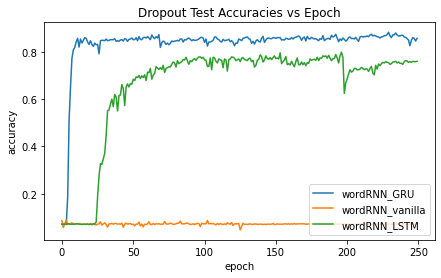

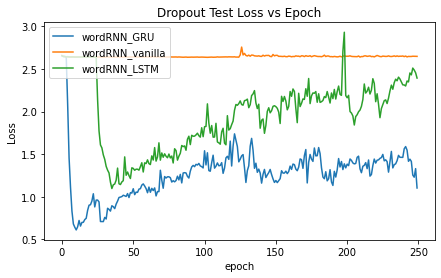

In [15]:
plt.figure(figsize=(7,4))
plt.plot(histories['wordRNN_GRU']['test_acc'])
plt.plot(histories['wordRNN_vanilla']['test_acc'])
plt.plot(histories['wordRNN_LSTM']['test_acc'])
plt.title('Dropout Test Accuracies vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['wordRNN_GRU','wordRNN_vanilla','wordRNN_LSTM'], loc='lower right')

plt.savefig(
    f'./results/partB_qn6_wordRNN_clipping_accuracies.pdf'
)

plt.figure(figsize=(7,4))
plt.plot(histories['wordRNN_GRU']['test_loss'])
plt.plot(histories['wordRNN_vanilla']['test_loss'])
plt.plot(histories['wordRNN_LSTM']['test_loss'])
plt.title('Dropout Test Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['wordRNN_GRU','wordRNN_vanilla','wordRNN_LSTM'], loc='upper left')

plt.savefig(
    f'./results/partB_qn6_wordRNN_clipping_loss.pdf'
)